In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE





from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier


import warnings
warnings.filterwarnings('ignore')



In [3]:
# Load and preprocess the data 
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
data.describe()   

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [9]:
cols_data = data.columns[1:].to_list()

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [10]:
plt.figure(figsize=(10, 30))
for i in range(len(cols_data)):
    plt.subplot(6, 2, i+1)
    sns.histplot(data[cols_data[i]], kde=True)
    plt.title(cols_data[i])


NameError: name 'cols_data' is not defined

<Figure size 1000x3000 with 0 Axes>

In [7]:
data.select_dtypes(exclude='object').corr()["stroke"].sort_values(ascending=False)


stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
id                   0.006388
Name: stroke, dtype: float64

In [8]:
data.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [9]:
#drop the rows with other
data[data["gender"] == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [10]:
data = data.drop(data[data["gender"] == "Other"].index)

In [11]:
data.age[data.age < 1].value_counts()


age
0.88    5
0.32    5
0.24    5
0.72    5
0.56    5
0.64    4
0.80    4
0.48    3
0.16    3
0.40    2
0.08    2
Name: count, dtype: int64

In [15]:
#find the number of rows with age less than 1
data[data.age < 1].shape[0]




43

In [17]:
#check the working status of children less than 1 year
data[data.age < 1].work_type.value_counts()

work_type
children    43
Name: count, dtype: int64

In [18]:
#check for other in gender
data[data["gender"] == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [19]:
#check for min and max age
data["age"].min(), data["age"].max()    

(0.08, 82.0)

<Axes: title={'center': 'Stroke Distribution'}, xlabel='Stroke', ylabel='Percentage'>

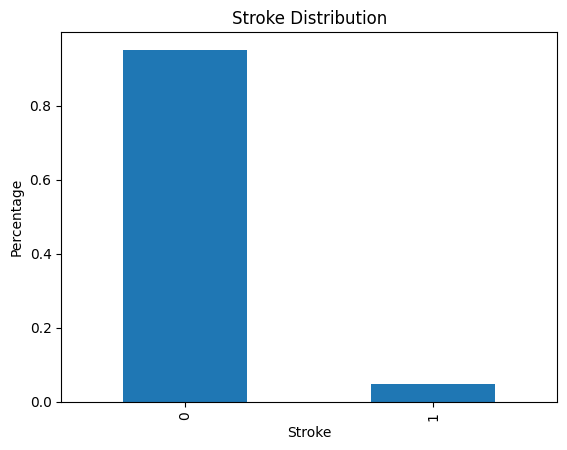

In [14]:
data["stroke"].value_counts(normalize=True).plot(
    kind='bar',
    xlabel='Stroke',
    ylabel='Percentage',
    title='Stroke Distribution')

Text(0.5, 1.0, 'Distribution of stroke/age Ratio, by Class')

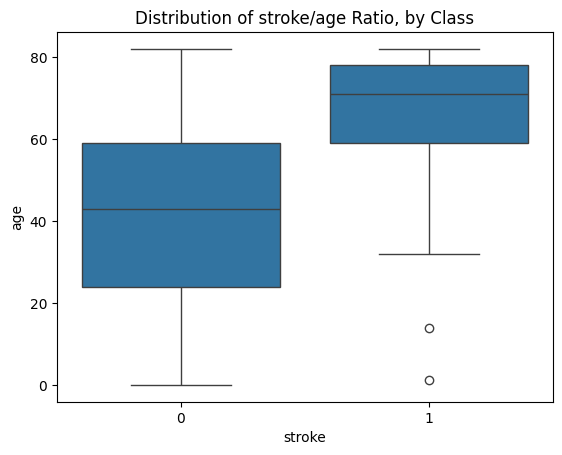

In [15]:
# Create boxplot
sns.boxplot(x="stroke", y="age" , data=data)
plt.xlabel("stroke")
plt.ylabel("age")
plt.title("Distribution of stroke/age Ratio, by Class")

In [16]:
data["age"].describe().apply("{0:,.0f}".format)

count    5,109
mean        43
std         23
min          0
25%         25
50%         45
75%         61
max         82
Name: age, dtype: object

Text(0.5, 1.0, 'Distribution of stroke/avg_glucose_level Ratio, by Class')

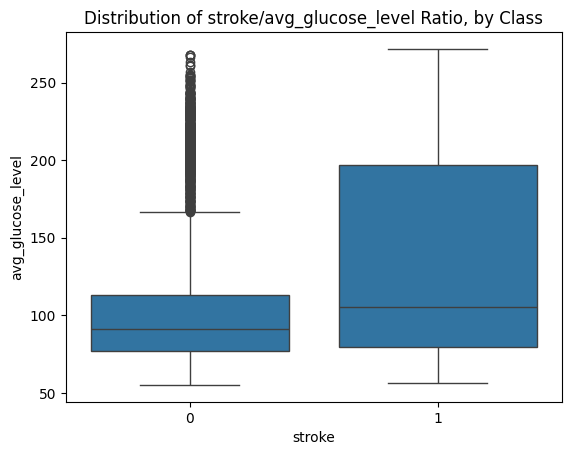

In [17]:
# Create boxplot
sns.boxplot(x="stroke", y="avg_glucose_level" , data=data)
plt.xlabel("stroke")
plt.ylabel("avg_glucose_level")
plt.title("Distribution of stroke/avg_glucose_level Ratio, by Class")

In [18]:
data["avg_glucose_level"].describe().apply("{0:,.0f}".format)

count    5,109
mean       106
std         45
min         55
25%         77
50%         92
75%        114
max        272
Name: avg_glucose_level, dtype: object

Text(0.5, 1.0, 'Distribution of stroke/bmi Ratio, by Class')

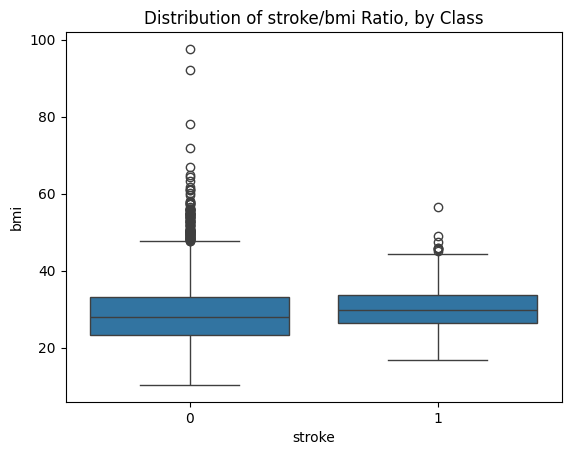

In [19]:
# Create boxplot
sns.boxplot(x="stroke", y="bmi" , data=data)
plt.xlabel("stroke")
plt.ylabel("bmi")
plt.title("Distribution of stroke/bmi Ratio, by Class")

In [20]:
data["bmi"].describe().apply("{0:,.0f}".format)


count    4,908
mean        29
std          8
min         10
25%         24
50%         28
75%         33
max         98
Name: bmi, dtype: object

In [21]:
bins = [0, 2, 18, 35, 65, np.inf]
labels = ['Infant', 'Child', 'Young Adult', 'Adult', 'Senior']
df_age = data.copy()
df_age['age_group'] = pd.cut(df_age['age'], bins=bins, labels=labels, right=False)


Text(0.5, 1.0, 'Distribution of age_groupLevel')

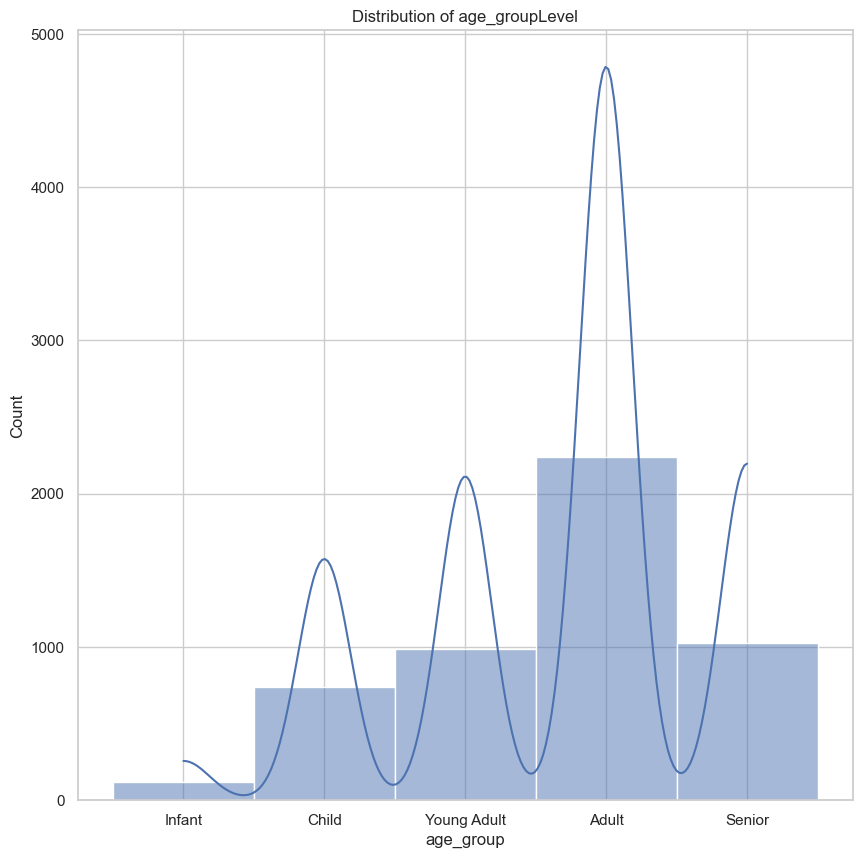

In [22]:
sns.set_theme(style="whitegrid")    
fig = plt.figure(figsize=(10, 10))
sns.histplot(df_age["age_group"], label="age_group", kde=True)
plt.title("Distribution of age_groupLevel")  

In [23]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [24]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [25]:
print(data["bmi"].mean())
print(data["bmi"].median())

28.894559902200488
28.1


In [26]:
data.work_type.value_counts()

work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [43]:
from sklearn.impute import KNNImputer
# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance')

# Apply the imputer to the entire dataset
# This will consider all other columns to impute 'bmi'
data_imputed =imputer.fit_transform(data[['bmi']])

# Update the original dataset with the imputed 'bmi' values
data['bmi'] = data_imputed[:, 0]	

In [28]:
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [29]:
data.bmi.describe().apply("{0:,.0f}".format)

count    5,109
mean        29
std          8
min         10
25%         24
50%         28
75%         33
max         98
Name: bmi, dtype: object

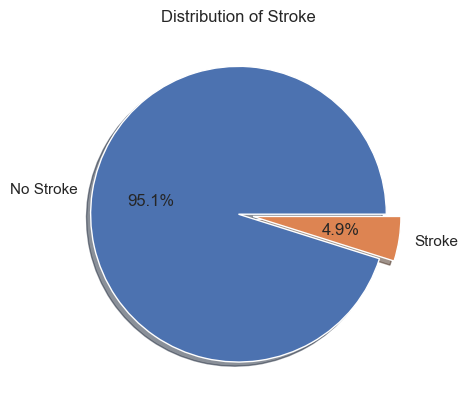

In [30]:
# Define the labels and values for the pie plot
labels = ['No Stroke', 'Stroke']
values = data.stroke.value_counts()

# Define the explode values to separate the slices
explode = (0, 0.1)

# Plot the pie plot
plt.pie(values, labels=labels, explode=explode, shadow=True, autopct='%1.1f%%')

# Add a title to the plot
plt.title('Distribution of Stroke')

# Display the plot
plt.show()


Text(0.5, 1.0, 'Distribution of Average Glucose Level')

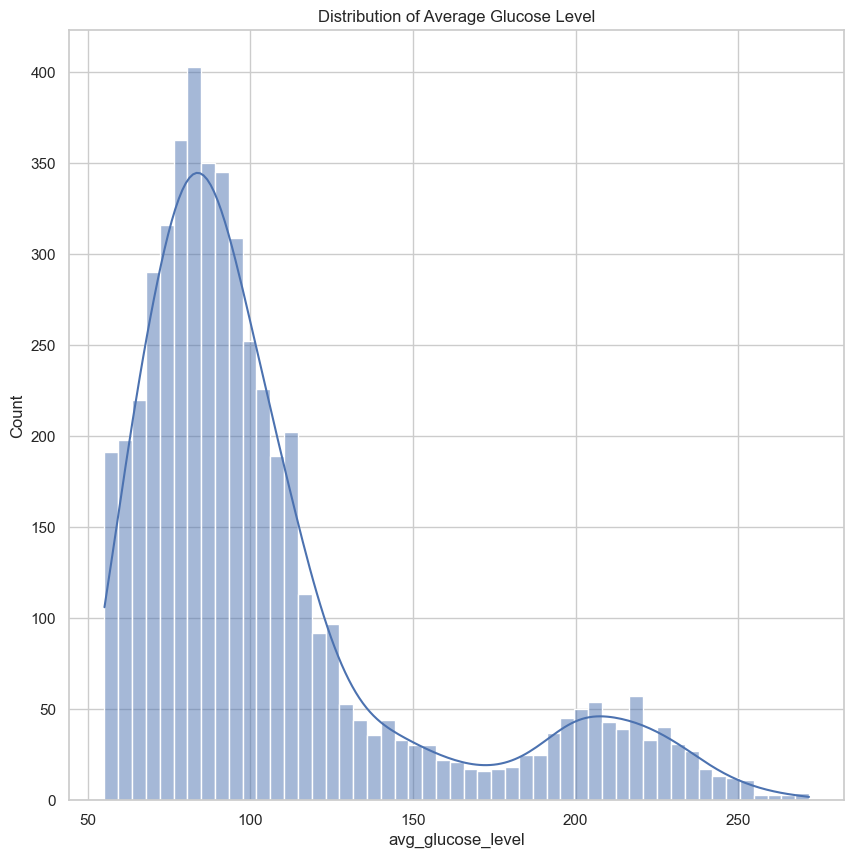

In [31]:
sns.set_theme(style="whitegrid")    
fig = plt.figure(figsize=(10, 10))
sns.histplot(data["avg_glucose_level"], label="avg_glucose_level", kde=True)
plt.title("Distribution of Average Glucose Level")  


Text(0.5, 1.0, 'Distribution of BMI')

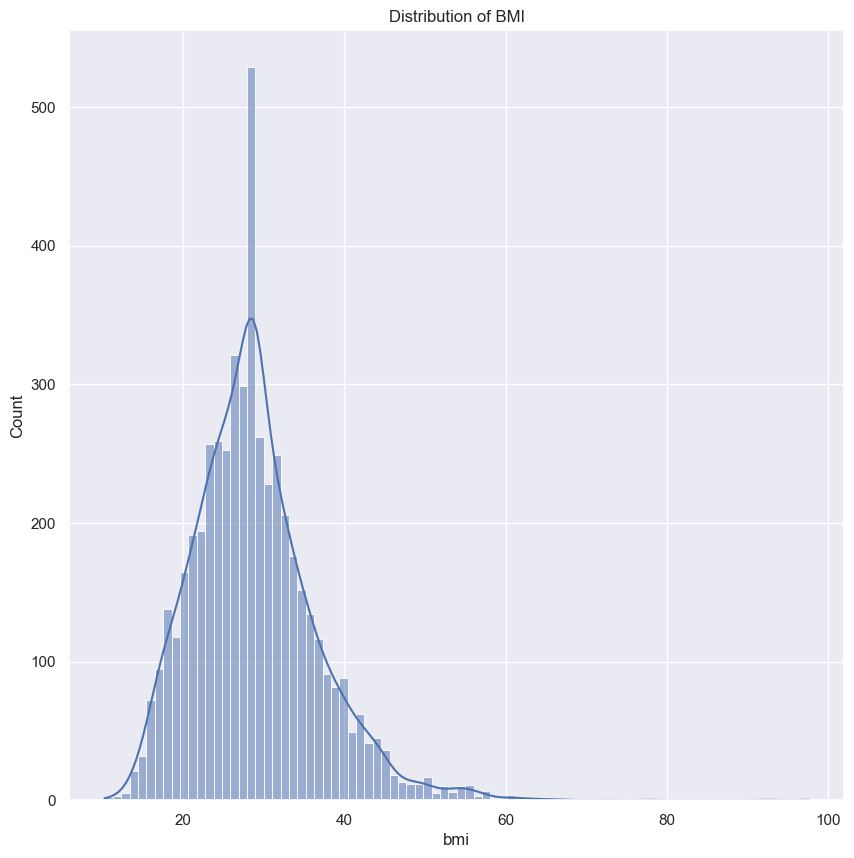

In [32]:
sns.set_theme(style="darkgrid")    
fig = plt.figure(figsize=(10, 10))
sns.histplot(data["bmi"], label="bmi", kde=True)
plt.title("Distribution of BMI") 

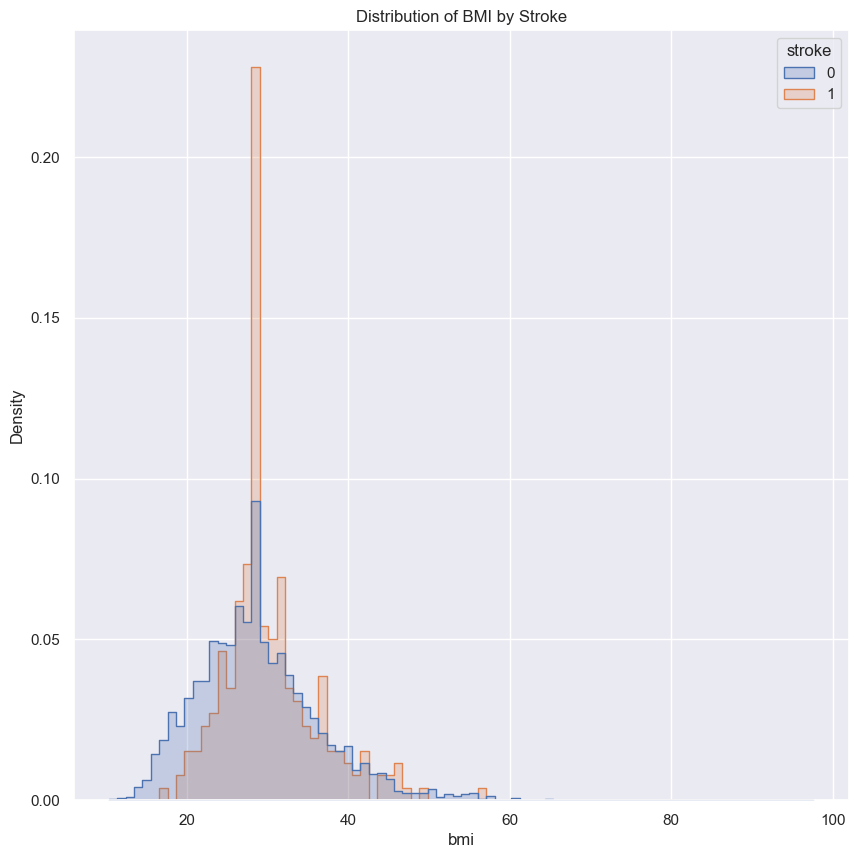

In [33]:
plt.figure(figsize=(10, 10))
sns.histplot(data,
             x="bmi", hue="stroke",
             element="step", 
             stat="density", common_norm=False)
plt.title("Distribution of BMI by Stroke")
plt.show()  


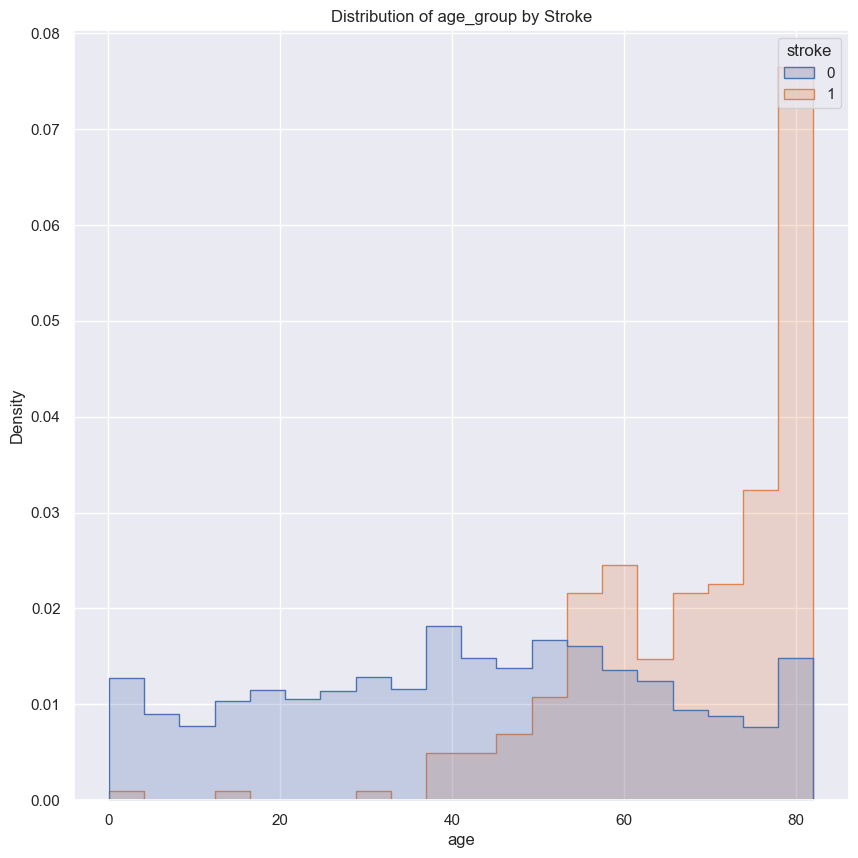

In [34]:
plt.figure(figsize=(10, 10))
sns.histplot(data,
             x="age", hue="stroke",
             element="step", 
             stat="density", common_norm=False)
plt.title("Distribution of age_group by Stroke")
plt.show()  


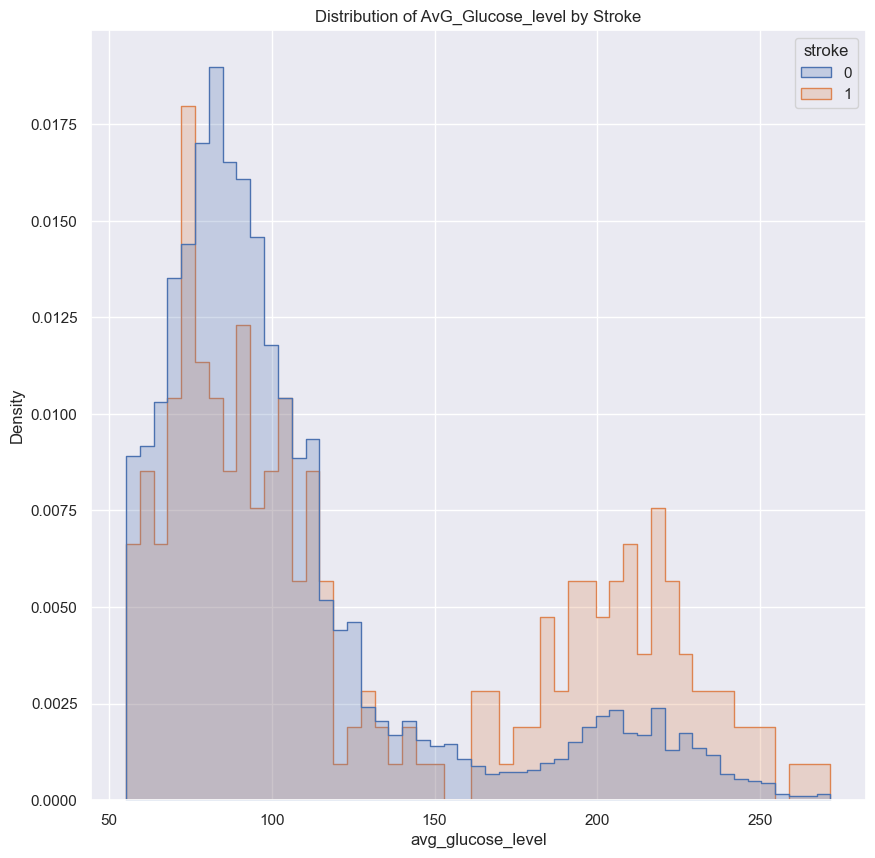

In [35]:
plt.figure(figsize=(10, 10))
sns.histplot(data,
             x="avg_glucose_level", hue="stroke",
             element="step", 
             stat="density", common_norm=False)
plt.title("Distribution of AvG_Glucose_level by Stroke")
plt.show()

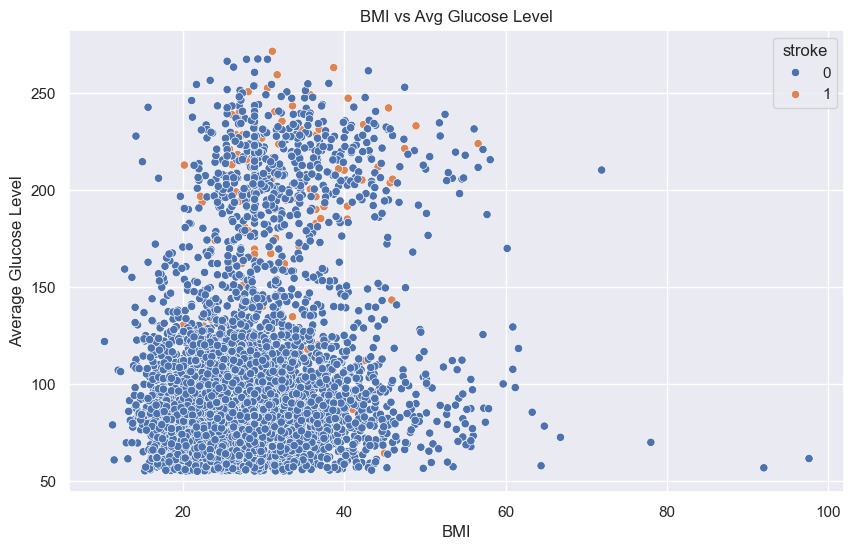

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='bmi', y='avg_glucose_level', hue='stroke')
plt.title('BMI vs Avg Glucose Level')
plt.xlabel('BMI')
plt.ylabel('Average Glucose Level')
plt.show()


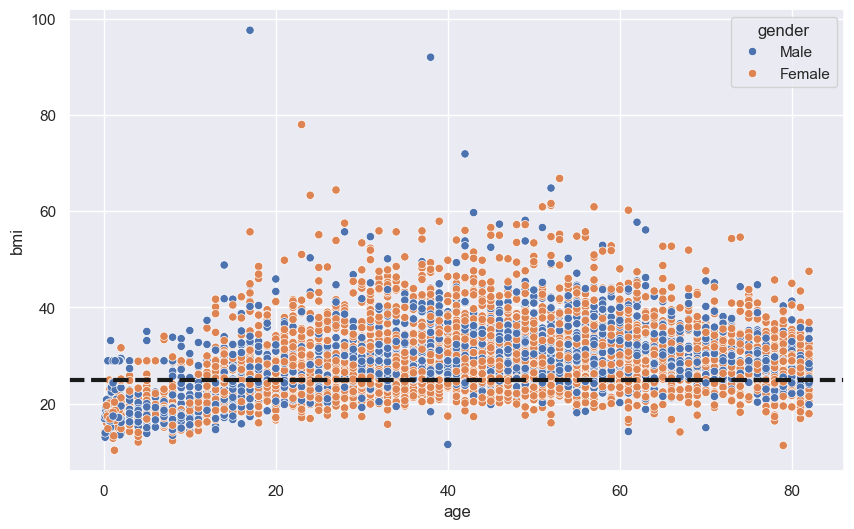

In [37]:
plt.figure(figsize=(10, 6))
fig = sns.scatterplot(data=data, x='age', y='bmi', hue='gender')
fig.axhline(y=25, linewidth=3, color='k', linestyle='--')
plt.show()

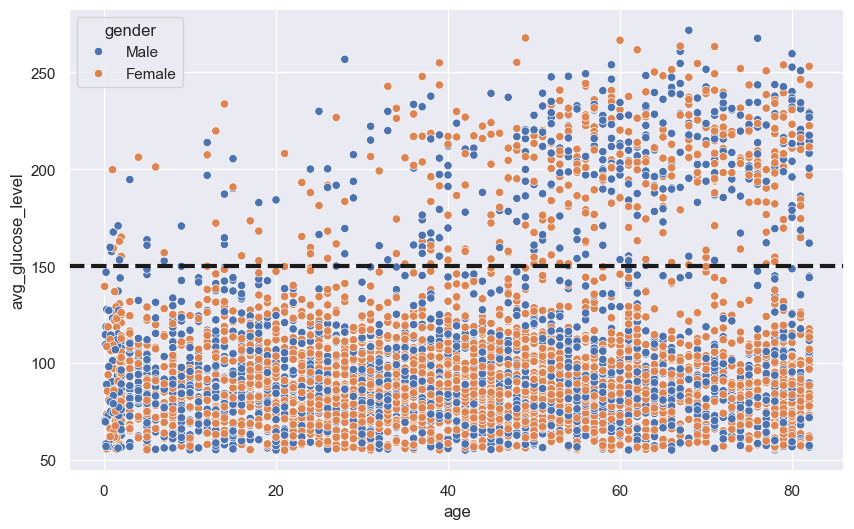

In [38]:
plt.figure(figsize=(10, 6))
fig = sns.scatterplot(data=data, x='age', y='avg_glucose_level', hue='gender')
fig.axhline(y=150, linewidth=3, color='k', linestyle='--')
plt.show()

In [39]:
q1, q9 = data["bmi"].quantile([0.1, 0.9])	

mask = data["bmi"].between(q1, q9)
mask.head()

0    True
1    True
2    True
3    True
4    True
Name: bmi, dtype: bool

Text(0.5, 1.0, 'Distribution of stroke/bmi Ratio, by Class')

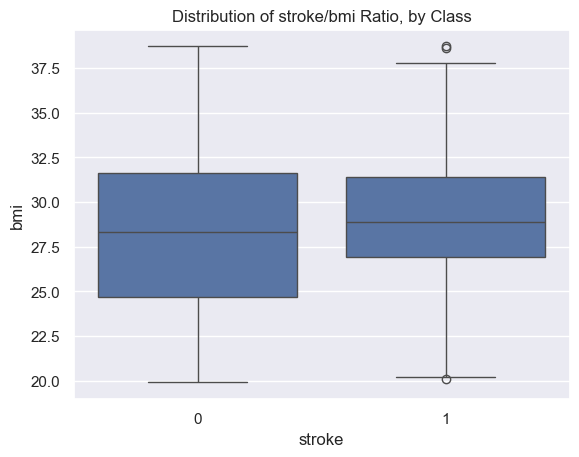

In [40]:
q1, q9 = data["bmi"].quantile([0.1, 0.9])	
mask = data["bmi"].between(q1, q9)
sns.boxplot(x="stroke", y="bmi" , data=data[mask])
plt.xlabel("stroke")
plt.ylabel("bmi")
plt.title("Distribution of stroke/bmi Ratio, by Class")

In [41]:
data.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of stroke/avg_glucose_level Ratio, by Class')

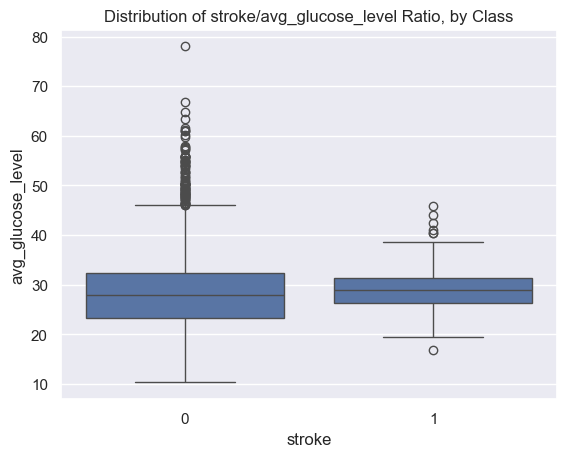

In [42]:
q1, q9 = data["avg_glucose_level"].quantile([0.1, 0.9])	
mask = data["avg_glucose_level"].between(q1, q9)
sns.boxplot(x="stroke", y="bmi" , data=data[mask])
plt.xlabel("stroke")
plt.ylabel("avg_glucose_level")
plt.title("Distribution of stroke/avg_glucose_level Ratio, by Class")

In [20]:
corr = data.drop(columns="stroke").corr(exclude="object")
sns.heatmap(corr)

TypeError: DataFrame.corr() got an unexpected keyword argument 'exclude'